In [100]:
import numpy as np
from scipy import optimize
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fast')

import utility_functions as fn

## Initialization

In [55]:
# read from csv into a new dataframe
raw_weather = pd.read_csv('../data/weather_raw.csv',index_col=1)

# reindex by appropriate datetime
raw_weather.index = pd.to_datetime(raw_weather.index,format='%Y-%m-%d %H:00:00 +0000 UTC')
raw_weather.index.names = ['']

# remove unused columns
unused = raw_weather.columns[np.array([0,1,2,3,4,9,10,13,15,16,17,19,20,21,23,24,25,26])]
raw_weather.drop(unused,axis=1,inplace=True)

# rename and reorder columns
column_names = ['temp','tmin','tmax','pressure','rh','wind','rain','snow','clouds']
raw_weather.columns = column_names
raw_weather = raw_weather[['temp','tmin','tmax','pressure','rh','wind','clouds','rain','snow']]

In [56]:
# drop duplicate rows
raw_weather.drop_duplicates(inplace=True)

# reindex to add missing rows, for a total length of 53545
correct_dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')
raw_weather = raw_weather.reindex(index=correct_dt)

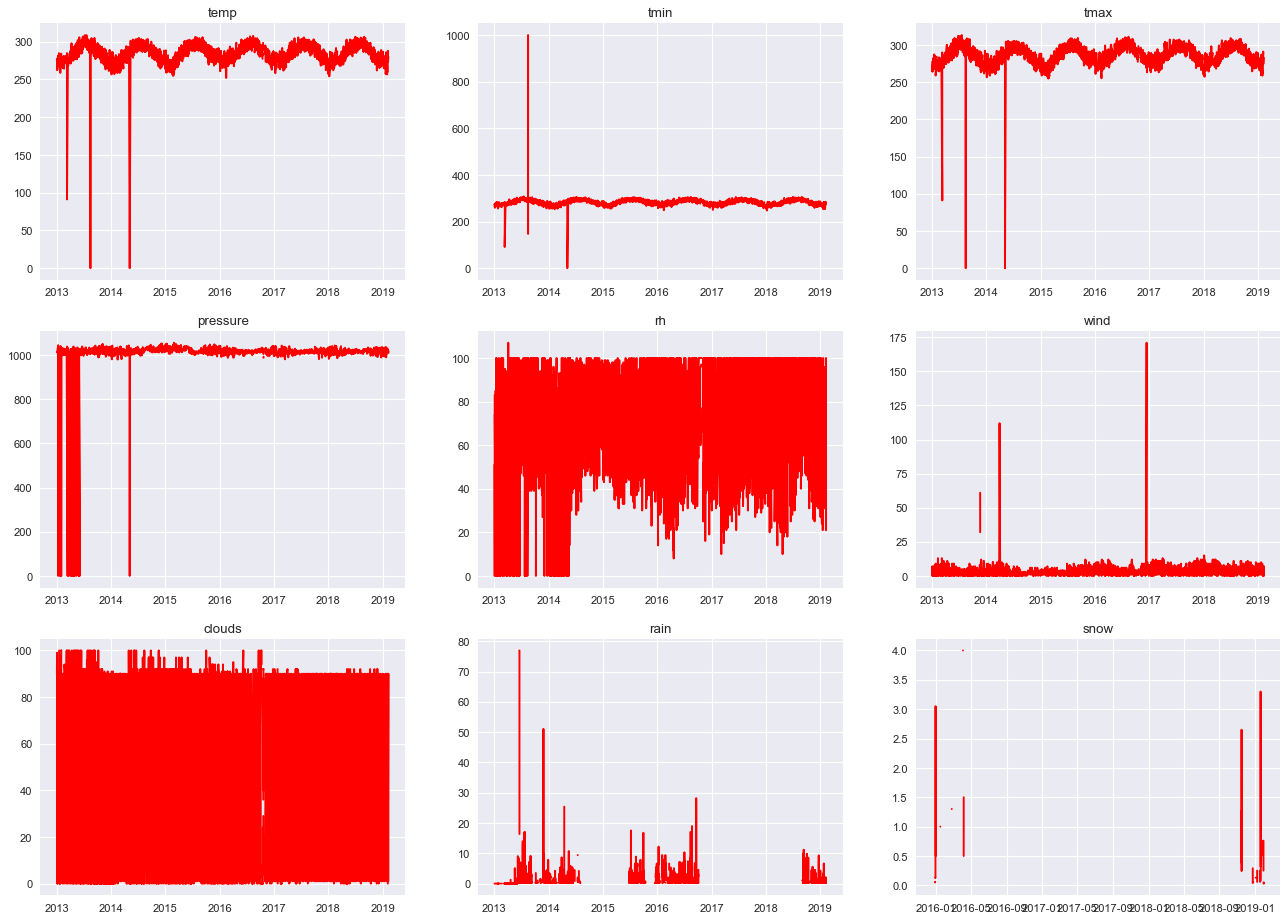

In [57]:
fn.plot_all(raw_weather,'2013-01-02 00:00:00','2019-02-09 00:00:00')
# print(raw_weather.isnull().sum())

## Error Identification
For this weather data, manual high and low "tuner" values are implemented to remove errors

In [58]:
# set violating values to NaN based on hardcoded low and high limit values for each column separately
sparse_weather = raw_weather.copy(deep=True)

low_tuners = [250,240,250,900,5,0,0,0,0]
high_tuners = [350,350,350,1100,100,25,100,100,10]
j=0

for i in raw_weather.columns:
    sparse_weather[i].where(sparse_weather[i] >= low_tuners[j],inplace=True)
    sparse_weather[i].where(sparse_weather[i] <= high_tuners[j],inplace=True)
    j=j+1

In [59]:
# assign NaN precip values to zero, this is an unconfirmed assumption
sparse_weather['rain'].replace(np.NaN,0,inplace=True)
sparse_weather['snow'].replace(np.NaN,0,inplace=True)

# set initial humidity value to suppress errors
sparse_weather['rh'][0] = 46

In [60]:
# fn.plot_feature(sparse_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
# print(sparse_weather.isnull().sum())

(array([736161., 736162., 736163., 736164., 736165., 736166., 736167.,
        736168., 736169.]), <a list of 9 Text xticklabel objects>)

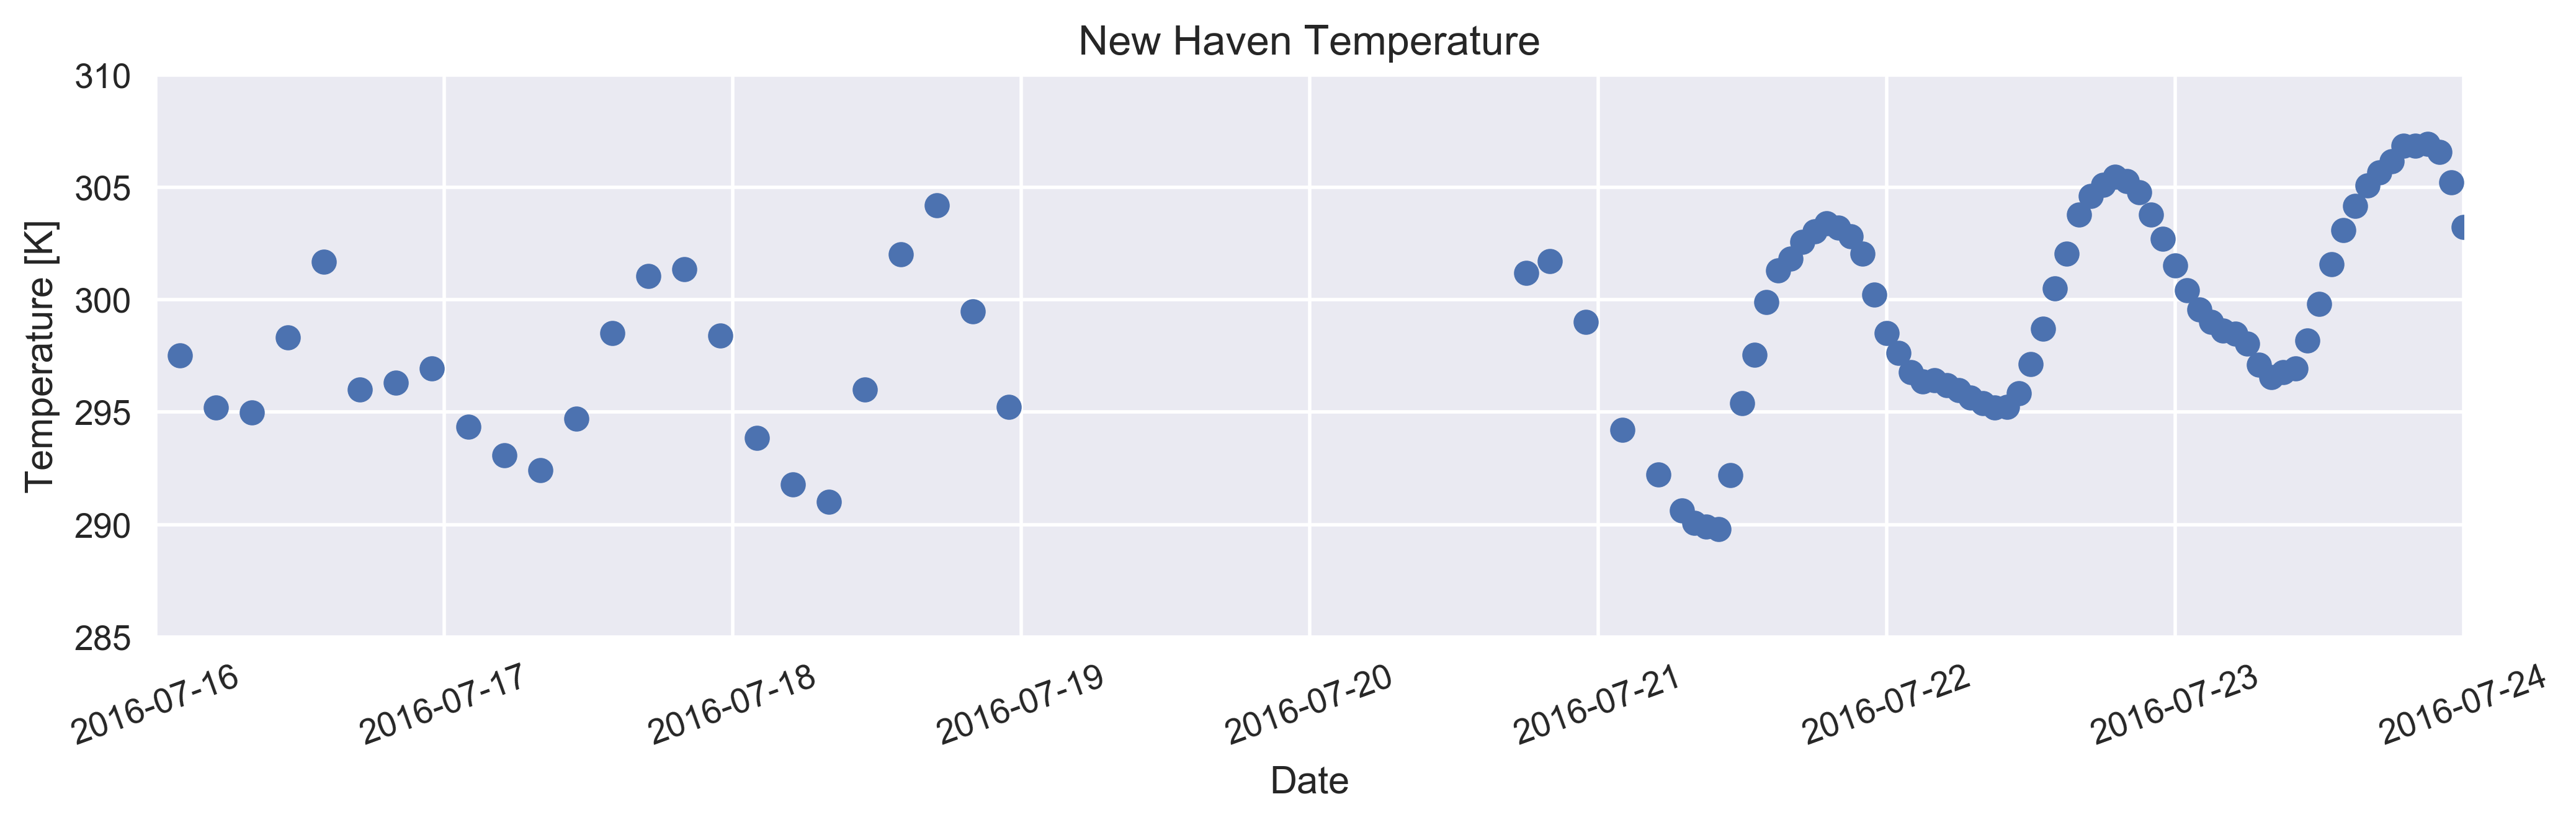

In [64]:
values1 = sparse_weather['temp'].loc['2016-07-16 00:00:00':'2016-07-24 00:00:00'].values
dates = sparse_weather['temp'].loc['2016-07-16 00:00:00':'2016-07-24 00:00:00'].index

fig, ax = plt.subplots(figsize=(12, 3),dpi=400)
ax.scatter(dates, values)

ax.set_xlabel('Date')
ax.set_xlim('2016-07-16 00:00:00','2016-07-24 00:00:00')

ax.set_ylabel('Temperature [K]')
ax.set_ylim(285,310)

ax.set_title('New Haven Temperature')
plt.xticks(rotation=20)


## Imputation
Gaps shorter than 6 hours are filled using linear interpolation.

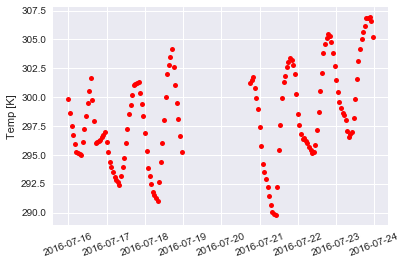

In [66]:
# impute missing ranges shorter than 6 hours using linear interpolation
dense0_weather = sparse_weather.copy(deep=True)

# interpolate gaps in consumption data 6 hours and shorter
for k in dense0_weather.columns:
    dense0_weather[k] = fn.limited_impute(dense0_weather[k],6)

fn.plot_feature(dense0_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
# print(dense_weather.isnull().sum())

The cell below implements sinusoidal imputation. For each gap, a sine curve is fit to the week of data before the gap. Then, the fit curve is extrapolated for the length of the gap. If the data to be fit are too messy, or not sinusoidal in nature, the gap is filled with the median value of the fit data. The results for each column are stored in a DataFrame called impute_results.

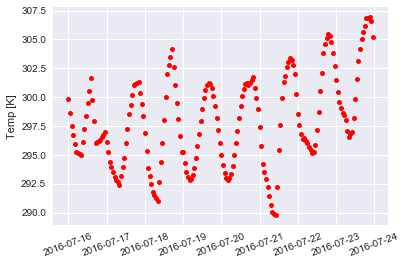

,sine,median
temp,9,0
tmin,9,0
tmax,9,0
pressure,12,0
rh,34,3
wind,10,0
clouds,9,0
rain,0,0
snow,0,0


In [69]:
# intermediate dataframe for plotting purposes
dense_weather = dense0_weather.copy(deep=True)

# initialize results dataframe
impute_results = pd.DataFrame(columns=['sine','median'])

# iterate through each column
for k in dense_weather.columns:
    
    # find gap locations and lengths
    series = dense_weather[k].copy(deep=True)
    gaps = fn.gaps(series)
    
    # initialize counters to track how many gaps were filled with sine vs linear
    sine_count,median_count = 0,0
    
    # iterate through list of gaps and fill each one using the week of data prior to the gap
    for i in gaps.index:  
        fit_data = series[gaps.start_int[i] - 24*7:gaps.start_int[i]]

        # first try sinusoidal imputation, then resort to median filling
        try:
            fit = fn.sine_fit(np.arange(len(fit_data)),fit_data.values)
            imputed_values = fit['fit'](np.arange(len(fit_data)+1,len(fit_data)+gaps.length[i]+1))
            sine_count = sine_count+1
        except:
            imputed_values = np.full(gaps.length[i],np.median(fit_data.values))
            median_count = median_count+1
      
        # replace the gap with the imputed values
        series[gaps.start_int[i]:gaps.end_int[i]] = imputed_values
    
    # store impute results
    impute_results.loc[k] = [sine_count,median_count]
    
    # replace the sparse data with the imputed data
    dense_weather[k] = series

fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
impute_results

## Export
For now, only temperature and relative humidity lag features are being considered for the predictive models. This cell removes other columns and adds the lag variables.

In [10]:
export = dense_weather.iloc[:,[0,4]].round(2)
for k in export.columns:
    for i in range(1,7):
        export[k+' -'+str(i)] = np.append(np.array([np.nan]*i),export[k].values[0:len(export)-i])

export = export.iloc[6:,:][['temp','temp -1','temp -2','temp -3','temp -4','temp -5','temp -6',
                            'rh','rh -1','rh -2','rh -3','rh -4','rh -5','rh -6',]]
export.head(3)

,temp,temp -1,temp -2,temp -3,temp -4,temp -5,temp -6,rh,rh -1,rh -2,rh -3,rh -4,rh -5,rh -6
2013-01-01 06:00:00,269.26,269.65,270.03,270.03,270.11,270.61,271.07,48.0,46.0,42.0,42.0,46.0,46.0,46.0
2013-01-01 07:00:00,269.22,269.26,269.65,270.03,270.03,270.11,270.61,50.0,48.0,46.0,42.0,42.0,46.0,46.0
2013-01-01 08:00:00,269.22,269.22,269.26,269.65,270.03,270.03,270.11,54.0,50.0,48.0,46.0,42.0,42.0,46.0


In [11]:
export.to_csv('../data/weather_clean.csv')

In [128]:
values1 = sparse_weather['temp'].loc['2016-07-16 00:00:00':'2016-07-24 00:00:00'].values

values1 = (values1 - 273.15)*(9/5)+32



array([    nan,     nan, 75.866 ,     nan,     nan, 71.699 ,     nan,
           nan, 71.3066,     nan,     nan, 77.3276,     nan,     nan,
       83.3504,     nan,     nan, 73.1552,     nan,     nan, 73.7006,
           nan,     nan, 74.8292,     nan,     nan, 70.1618,     nan,
           nan, 67.8776,     nan,     nan, 66.6878,     nan,     nan,
       70.8278,     nan,     nan, 77.6462,     nan,     nan, 82.211 ,
           nan,     nan, 82.7618,     nan,     nan, 77.45  ,     nan,
           nan, 69.26  ,     nan,     nan, 65.5592,     nan,     nan,
       64.1642,     nan,     nan, 73.1444,     nan,     nan, 83.975 ,
           nan,     nan, 87.8756,     nan,     nan, 79.4012,     nan,
           nan, 71.7584,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     

## Plots for presentation

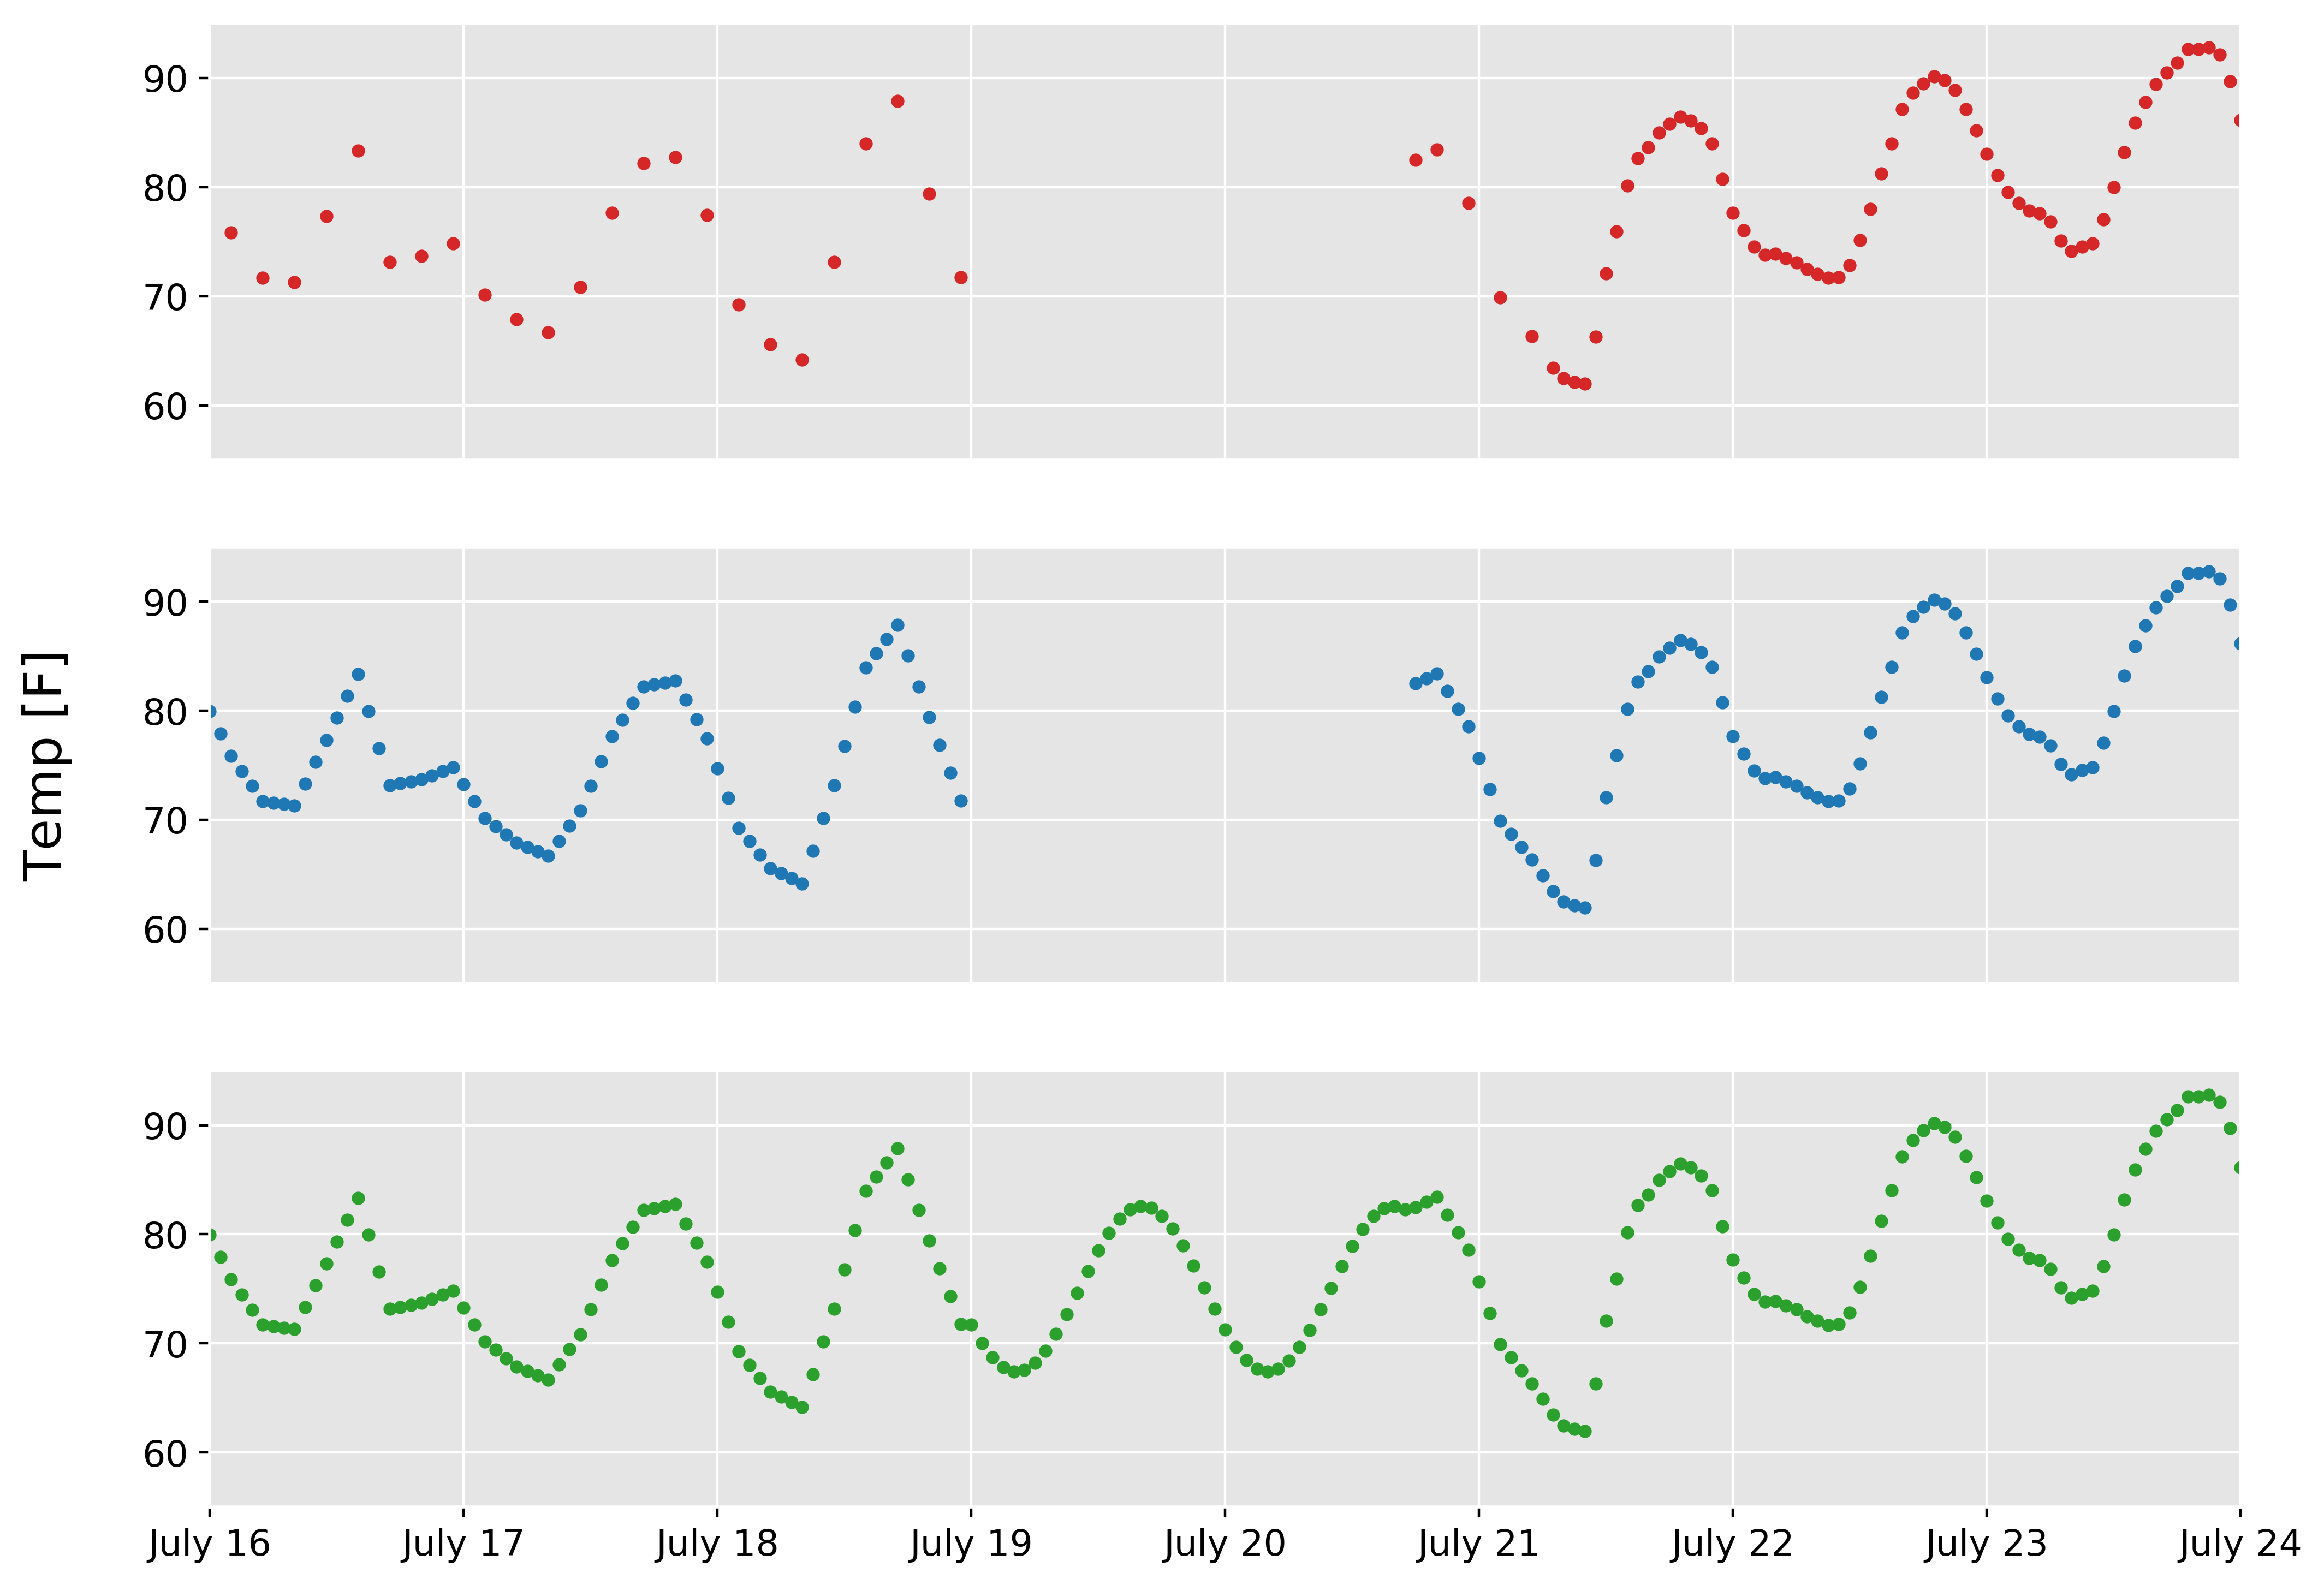

In [161]:
# reset plotting libraries
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('ggplot')

x_tick_labels = ['July 16','July 17','July 18','July 19','July 20','July 21','July 22','July 23','July 24']

values1 = sparse_weather['temp'].loc['2016-07-16 00:00:00':'2016-07-24 00:00:00'].values
values2 = dense0_weather['temp'].loc['2016-07-16 00:00:00':'2016-07-24 00:00:00'].values
values3 = dense_weather['temp'].loc['2016-07-16 00:00:00':'2016-07-24 00:00:00'].values
dates = sparse_weather['temp'].loc['2016-07-16 00:00:00':'2016-07-24 00:00:00'].index

# convert ot fahrenheit
values1 = (values1 - 273.15)*(9/5)+32
values2 = (values2 - 273.15)*(9/5)+32
values3 = (values3 - 273.15)*(9/5)+32

fig, [ax1,ax2,ax3] = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(12,9),dpi=400)
# plt.xticks(labels=x_ticks,rotation=25,color='k')

ax1.scatter(dates, values1,c='tab:red',s=15)
ax1.set_ylim(55,95)
ax1.tick_params(axis='x',size=0)
ax1.tick_params(axis='y',colors='k',labelsize=12)

ax2.scatter(dates, values2,c='tab:blue',s=15)
ax2.set_ylim(55,95)
ax2.tick_params(axis='x',size=0)
ax2.tick_params(axis='y',colors='k',labelsize=12)

ax3.scatter(dates, values3,c='tab:green',s=15)
ax3.set_ylim(55,95)
ax3.set_xticklabels(x_tick_labels)
ax3.tick_params(axis='x',colors='k',labelsize=12)
ax3.tick_params(axis='y',colors='k',labelsize=12)

ax2.set_ylabel('Temp [F]\n',size=17)
ax2.yaxis.label.set_color('black')

plt.xlim('2016-07-16 00:00:00','2016-07-24 00:00:00')

fig.savefig('../figures/imputation.png', bbox_inches='tight')